<a href="https://colab.research.google.com/github/Josshua-DSA/ARIMA-VAR-Forecast/blob/main/ARIMA-VAR_IHSG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Collection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

#extract dataset from drive folder
df = pd.read_csv('/content/drive/MyDrive/dataset/IHSG10yrs.csv', parse_dates=['Tanggal'])
# Parsing tanggal (format: 01/11/2025)
df["Tanggal"] = pd.to_datetime(df["Tanggal"], dayfirst=True)
df = df.sort_values("Tanggal").set_index("Tanggal")

# EDA

In [ ]:
df.head()

,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
Tanggal,,,,,,
2020-11-03,"5.159,45","5.133,98","5.162,35","5.131,95","10,14B","0,87%"
2020-11-04,"5.105,20","5.170,82","5.188,01","5.105,20","10,40B","-1,05%"
2020-11-05,"5.260,33","5.161,39","5.260,33","5.161,39","10,88B","3,04%"
2020-11-06,"5.335,53","5.276,16","5.335,53","5.246,70","10,47B","1,43%"
2020-11-09,"5.356,01","5.371,97","5.395,71","5.319,42","12,15B","0,38%"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1207 entries, 2020-11-03 to 2025-11-03
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Terakhir    1207 non-null   object
 1   Pembukaan   1207 non-null   object
 2   Tertinggi   1207 non-null   object
 3   Terendah    1207 non-null   object
 4   Vol.        1204 non-null   object
 5   Perubahan%  1207 non-null   object
dtypes: object(6)
memory usage: 66.0+ KB


# PreProcessing

In [ ]:
# =========================
# 2. FUNGSI KONVERSI ANGKA FORMAT INDONESIA
# =========================
def parse_id_number(x):
    x = str(x)
    x = x.replace(".", "").replace(",", ".")
    return float(x)

def parse_volume_bil(x):
    # contoh: "787,61B" -> 787.61
    s = str(x).replace("B", "")
    s = s.replace(".", "").replace(",", ".")
    return float(s)

def parse_pct(x):
    # contoh: "1,58%" -> 0.0158
    s = str(x).replace("%", "")
    s = s.replace(".", "").replace(",", ".")
    return float(s) / 100.0

In [ ]:
# =========================
# 3. BUAT KOLOM NUMERIK
# =========================
df["Close"] = df["Terakhir"].apply(parse_id_number)
df["Open"]  = df["Pembukaan"].apply(parse_id_number)
df["High"]  = df["Tertinggi"].apply(parse_id_number)
df["Low"]   = df["Terendah"].apply(parse_id_number)
df["Vol_bil"] = df["Vol."].apply(parse_volume_bil)
df["Ret_pct"] = df["Perubahan%"].apply(parse_pct)

# Seri utama
ts_close = df["Close"].copy()
ts_ret   = df["Ret_pct"].copy()

print(df[["Terakhir", "Close", "Perubahan%", "Ret_pct"]].head())

            Terakhir    Close Perubahan%  Ret_pct
Tanggal                                          
2020-11-03  5.159,45  5159.45      0,87%   0.0087
2020-11-04  5.105,20  5105.20     -1,05%  -0.0105
2020-11-05  5.260,33  5260.33      3,04%   0.0304
2020-11-06  5.335,53  5335.53      1,43%   0.0143
2020-11-09  5.356,01  5356.01      0,38%   0.0038


In [ ]:
df.head()

,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%,Close,Open,High,Low,Vol_bil,Ret_pct
Tanggal,,,,,,,,,,,,
2020-11-03,"5.159,45","5.133,98","5.162,35","5.131,95","10,14B","0,87%",5159.45,5133.98,5162.35,5131.95,10.14,0.0087
2020-11-04,"5.105,20","5.170,82","5.188,01","5.105,20","10,40B","-1,05%",5105.20,5170.82,5188.01,5105.20,10.40,-0.0105
2020-11-05,"5.260,33","5.161,39","5.260,33","5.161,39","10,88B","3,04%",5260.33,5161.39,5260.33,5161.39,10.88,0.0304
2020-11-06,"5.335,53","5.276,16","5.335,53","5.246,70","10,47B","1,43%",5335.53,5276.16,5335.53,5246.70,10.47,0.0143
2020-11-09,"5.356,01","5.371,97","5.395,71","5.319,42","12,15B","0,38%",5356.01,5371.97,5395.71,5319.42,12.15,0.0038


In [ ]:
df.isnull().sum()

,0
Terakhir,0
Pembukaan,0
Tertinggi,0
Terendah,0
Vol.,3
Perubahan%,0
Close,0
Open,0
High,0
Low,0


# ARIMA - VAR

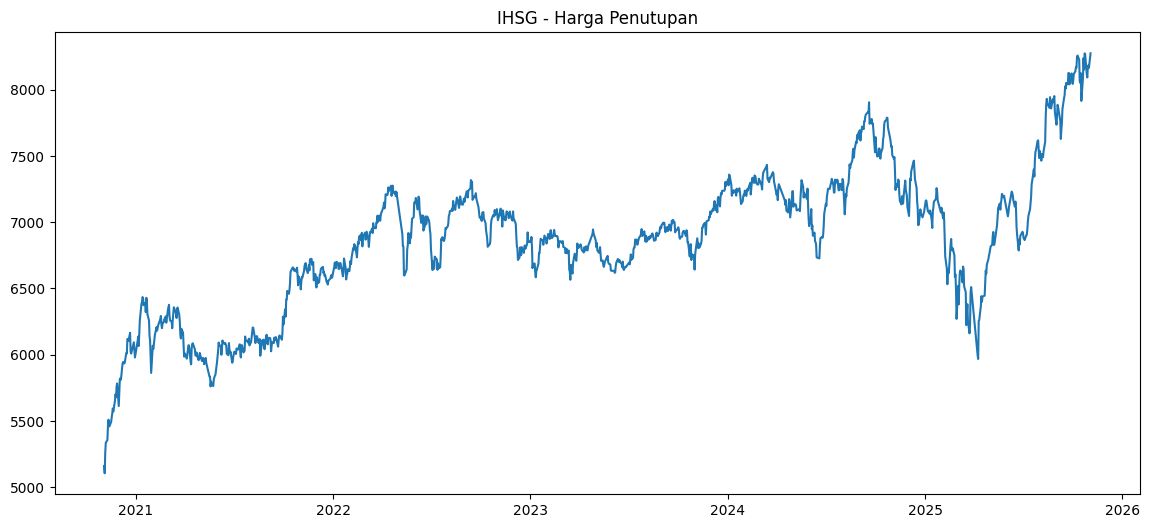

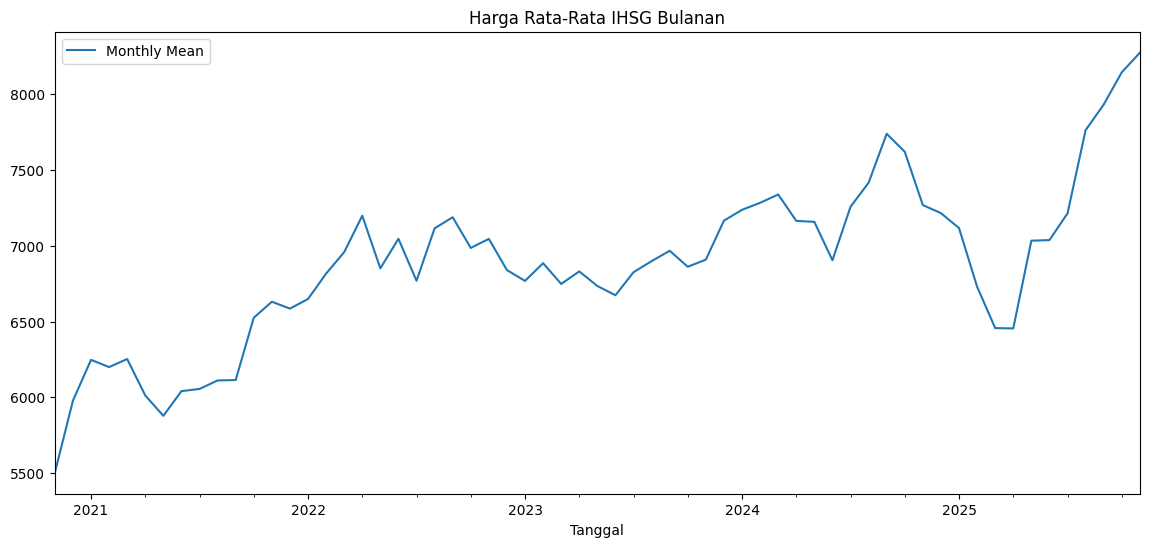

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['Close'])
plt.title('IHSG - Harga Penutupan')
plt.show()

# Periksa pola musiman
plt.figure(figsize=(14,6))
df['Close'].resample('M').mean().plot(label='Monthly Mean')
plt.title("Harga Rata-Rata IHSG Bulanan")
plt.legend()
plt.show()

## Identifikasi

In [ ]:
# =========================
# 1. UJI ADF – STASIONERITAS
# =========================

def adf_test(series, name=""):
    result = adfuller(series.dropna())
    print(f"ADF {name}: stat={result[0]:.4f}, p-value={result[1]:.4f}")
    if result[1] < 0.05:
        print(f"Data {name} stasioner!")
    else:
        print(f"Data {name} tidak stasioner, perlu differencing.")
    return result[1]

# Uji ADF untuk harga penutupan
print("Uji ADF Level (Harga Penutupan):")
adf_test(df['Close'], "Close")

# Jika tidak stasioner, lakukan differencing 1
df['Close_diff'] = df['Close'].diff().dropna()
print("\nUji ADF pada Diff(1) (Harga Penutupan):")
adf_test(df['Close_diff'], "Close Diff(1)")

Uji ADF Level (Harga Penutupan):
ADF Close: stat=-2.1616, p-value=0.2205
Data Close tidak stasioner, perlu differencing.

Uji ADF pada Diff(1) (Harga Penutupan):
ADF Close Diff(1): stat=-19.7638, p-value=0.0000
Data Close Diff(1) stasioner!


0.0

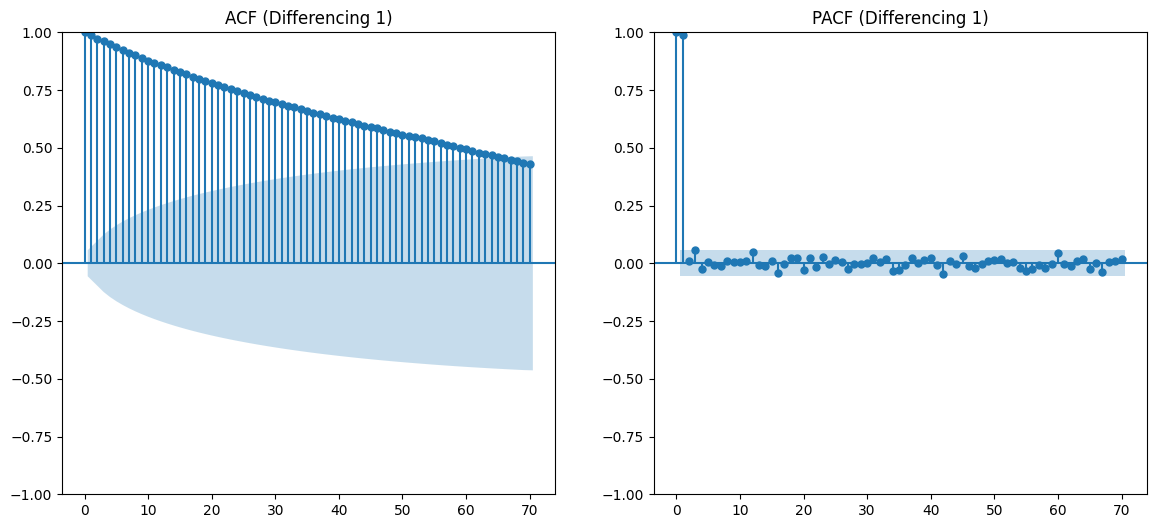

In [ ]:
# =========================
# 2. ACF & PACF PLOT untuk Identifikasi p dan q
# =========================

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot ACF (AutoCorrelation Function) untuk melihat nilai q (MA)
plot_acf(df['Close'], lags=70, ax=ax[0])
ax[0].set_title("ACF (Differencing 1)")

# Plot PACF (Partial AutoCorrelation Function) untuk melihat nilai p (AR)
plot_pacf(df['Close'], lags=70, ax=ax[1])
ax[1].set_title("PACF (Differencing 1)")

plt.show()

## Estimasi

In [ ]:
# Periksa apakah data sudah stasioner (jika p-value < 0.05 maka data stasioner)
p_value = adf_test(df['Close'])
print(f"ADF p-value: {p_value}")

# Tentukan grid search untuk p, d, q
p_values = range(0, 4)  # p dari 0 sampai 3
d_values = range(0, 2)  # d hanya 0 atau 1 (differencing)
q_values = range(0, 4)  # q dari 0 sampai 3

# Simpan hasil terbaik
best_aic = np.inf
best_order = None
best_model = None

# Grid search untuk menemukan p, d, q terbaik berdasarkan AIC
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                print(f"Trying ARIMA({p},{d},{q})...")
                model = ARIMA(df['Close'], order=(p, d, q))
                model_fit = model.fit()
                # Simpan hasil terbaik (AIC terkecil)
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except Exception as e:
                print(f"Model ARIMA({p},{d},{q}) gagal: {e}")

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

# Tampilkan summary dari model terbaik
print(best_model.summary())

result_arima = best_model

ADF : stat=-2.1616, p-value=0.2205
Data  tidak stasioner, perlu differencing.
ADF p-value: 0.22046540033098128
Trying ARIMA(0,0,0)...
Trying ARIMA(0,0,1)...
Trying ARIMA(0,0,2)...
Trying ARIMA(0,0,3)...
Trying ARIMA(0,1,0)...
Trying ARIMA(0,1,1)...
Trying ARIMA(0,1,2)...
Trying ARIMA(0,1,3)...
Trying ARIMA(1,0,0)...
Trying ARIMA(1,0,1)...
Trying ARIMA(1,0,2)...
Trying ARIMA(1,0,3)...
Trying ARIMA(1,1,0)...
Trying ARIMA(1,1,1)...
Trying ARIMA(1,1,2)...
Trying ARIMA(1,1,3)...
Trying ARIMA(2,0,0)...
Trying ARIMA(2,0,1)...
Trying ARIMA(2,0,2)...
Trying ARIMA(2,0,3)...
Trying ARIMA(2,1,0)...
Trying ARIMA(2,1,1)...
Trying ARIMA(2,1,2)...
Trying ARIMA(2,1,3)...
Trying ARIMA(3,0,0)...
Trying ARIMA(3,0,1)...
Trying ARIMA(3,0,2)...
Trying ARIMA(3,0,3)...
Trying ARIMA(3,1,0)...
Trying ARIMA(3,1,1)...
Trying ARIMA(3,1,2)...
Trying ARIMA(3,1,3)...
Best ARIMA order: (0, 1, 3) with AIC: 13350.480836822087
                               SARIMAX Results                                
Dep. Variable:   

## Cek Diagnostik

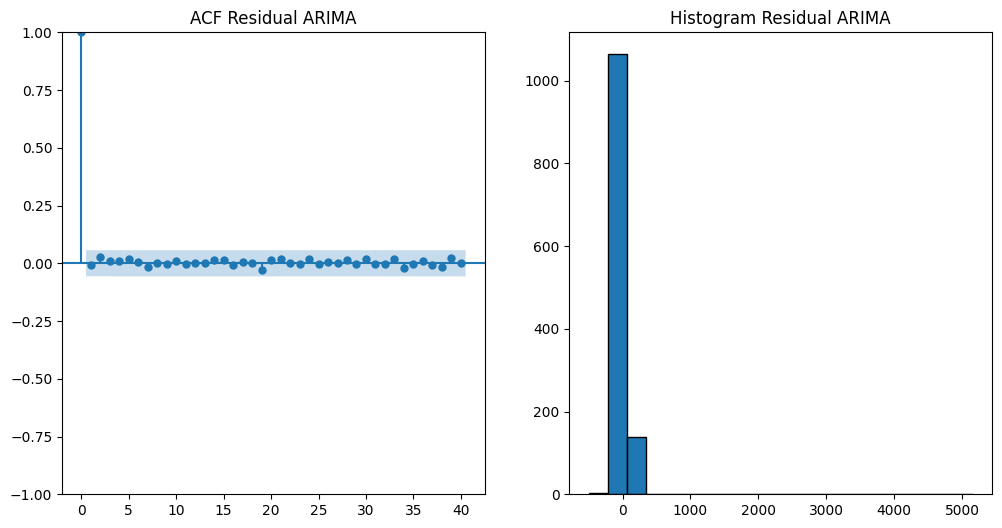

Ljung-Box test p-value: 1     0.745708
2     0.649499
3     0.798243
4     0.895100
5     0.906352
6     0.952898
7     0.964801
8     0.983703
9     0.992813
10    0.996195
Name: lb_pvalue, dtype: float64


In [ ]:
# Uji residual ARIMA
residual_arima = result_arima.resid
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plot_acf(residual_arima, lags=40, ax=plt.gca())
plt.title('ACF Residual ARIMA')
plt.subplot(1, 2, 2)
plt.hist(residual_arima, bins=20, edgecolor='black')
plt.title('Histogram Residual ARIMA')
plt.show()

# Uji Ljung-Box untuk ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_test = acorr_ljungbox(residual_arima, lags=10)
print(f"Ljung-Box test p-value: {ljung_box_test['lb_pvalue']}")

## Forecast

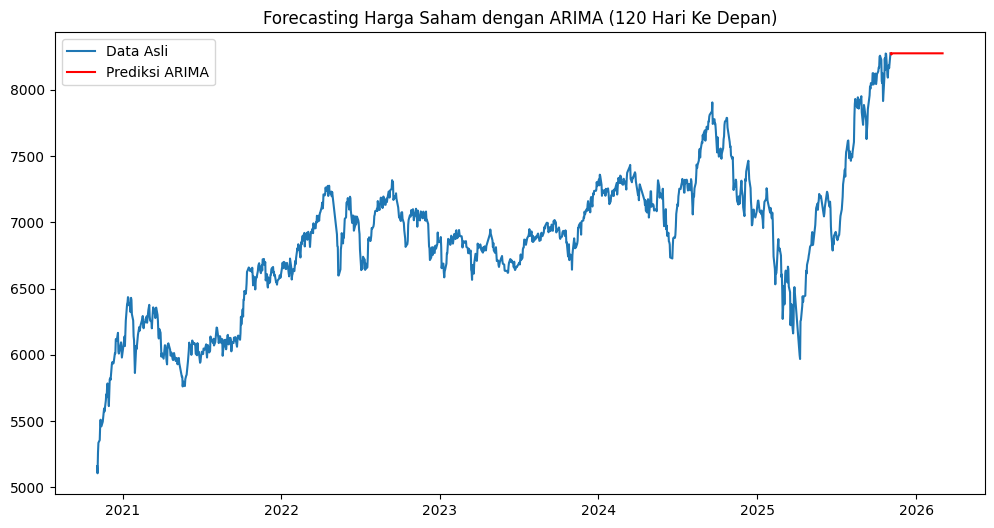

In [ ]:
# Peramalan ARIMA (Forecast) menggunakan metode forecast()
forecast_steps = 120

# Forecast langkah ke depan
forecast_arima = result_arima.forecast(steps=forecast_steps)

# Visualisasi hasil prediksi ARIMA
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Data Asli')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast_arima, color='red', label='Prediksi ARIMA')
plt.title(f'Forecasting Harga Saham dengan ARIMA ({forecast_steps} Hari Ke Depan)')
plt.legend()
plt.show()

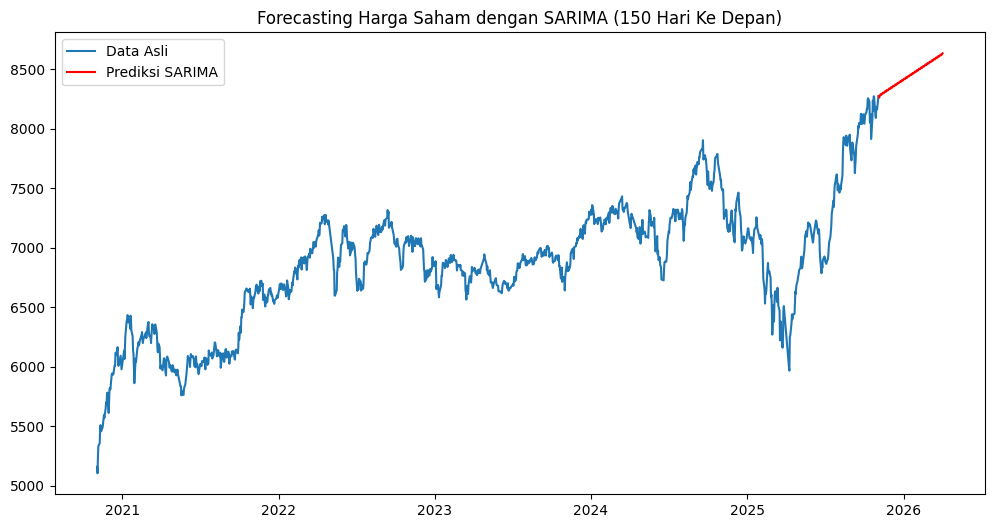

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Menentukan model SARIMA (Seasonal ARIMA)
sarima_model = SARIMAX(df['Close'],
                       order=(0, 1, 3),     # (p, d, q)
                       seasonal_order=(1, 1, 1, 5),  # (P, D, Q, S)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the model
sarima_result = sarima_model.fit()

# Forecast
forecast_steps = 150
forecast_sarima = sarima_result.forecast(steps=forecast_steps)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Data Asli')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast_sarima, color='red', label='Prediksi SARIMA')
plt.title(f'Forecasting Harga Saham dengan SARIMA ({forecast_steps} Hari Ke Depan)')
plt.legend()
plt.show()

#

# VAR

In [ ]:
data_var = df[['Close','Open','High','Low', 'Vol_bil',	'Ret_pct' ]]

In [ ]:
data_var.head()

,Close,Open,High,Low,Vol_bil,Ret_pct
Tanggal,,,,,,
2020-11-03,5159.45,5133.98,5162.35,5131.95,10.14,0.0087
2020-11-04,5105.20,5170.82,5188.01,5105.20,10.40,-0.0105
2020-11-05,5260.33,5161.39,5260.33,5161.39,10.88,0.0304
2020-11-06,5335.53,5276.16,5335.53,5246.70,10.47,0.0143
2020-11-09,5356.01,5371.97,5395.71,5319.42,12.15,0.0038


In [ ]:
data_var.isnull().sum()

,0
Close,0
Open,0
High,0
Low,0
Vol_bil,3
Ret_pct,0


In [ ]:
# Fill missing 'Vol_bil' values using nearest neighbor interpolation
data_var['Vol_bil'] = data_var['Vol_bil'].interpolate(method='nearest')
data_var.isnull().sum()

,0
Close,0
Open,0
High,0
Low,0
Vol_bil,0
Ret_pct,0


## Identifikasi

In [ ]:
# Menampilkan analisis awal
print("Descriptive Statistics for VAR")
print(data_var.describe())

Descriptive Statistics for VAR
             Close         Open         High          Low      Vol_bil  \
count  1207.000000  1207.000000  1207.000000  1207.000000  1207.000000   
mean   6864.769238  6868.538956  6904.741226  6825.486918    19.093289   
std     530.982150   532.231357   532.794528   531.070524     6.446708   
min    5105.200000  5133.980000  5162.350000  5105.200000     8.520000   
25%    6615.835000  6618.840000  6656.545000  6576.640000    14.765000   
50%    6897.950000  6897.980000  6932.460000  6863.670000    17.560000   
75%    7182.325000  7186.680000  7224.400000  7144.955000    21.675000   
max    8275.080000  8322.220000  8354.670000  8271.720000    61.510000   

           Ret_pct  
count  1207.000000  
mean      0.000441  
std       0.009097  
min      -0.079000  
25%      -0.004500  
50%       0.000700  
75%       0.005600  
max       0.047900  


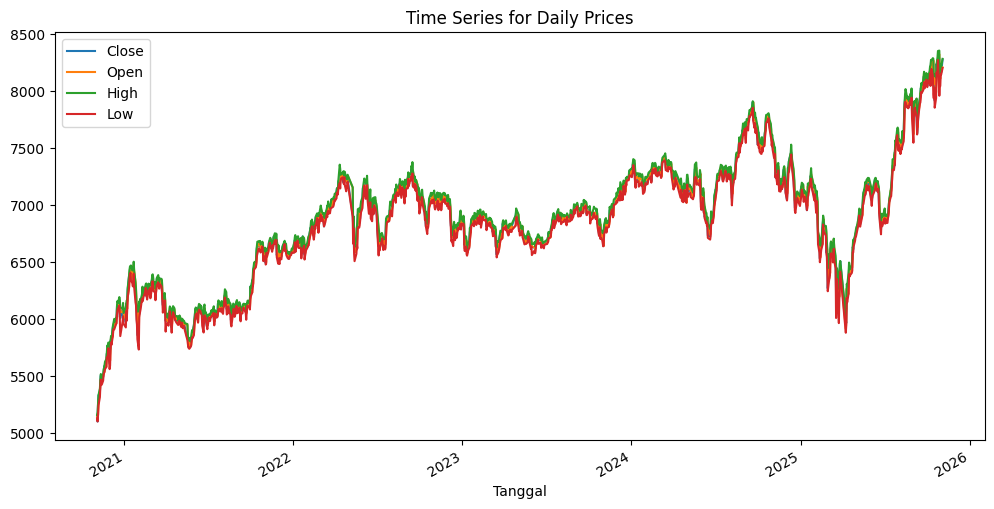

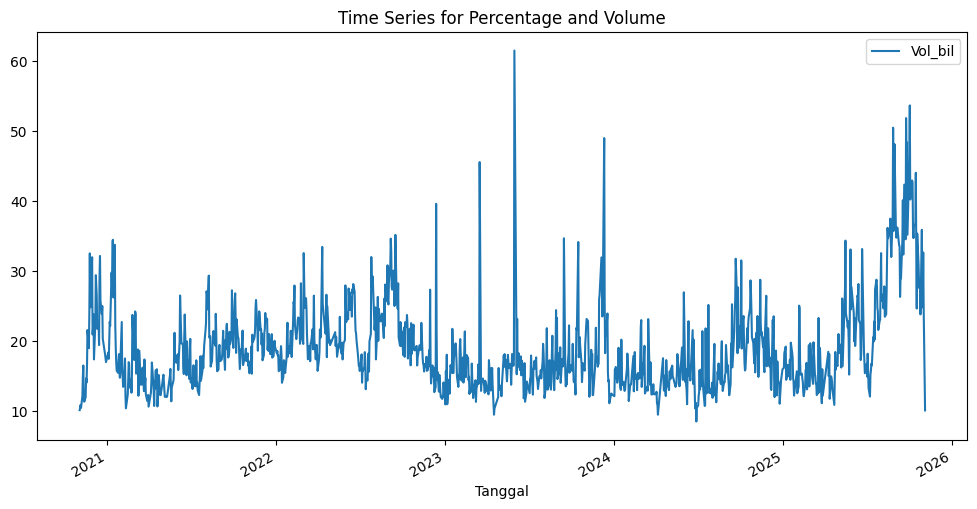

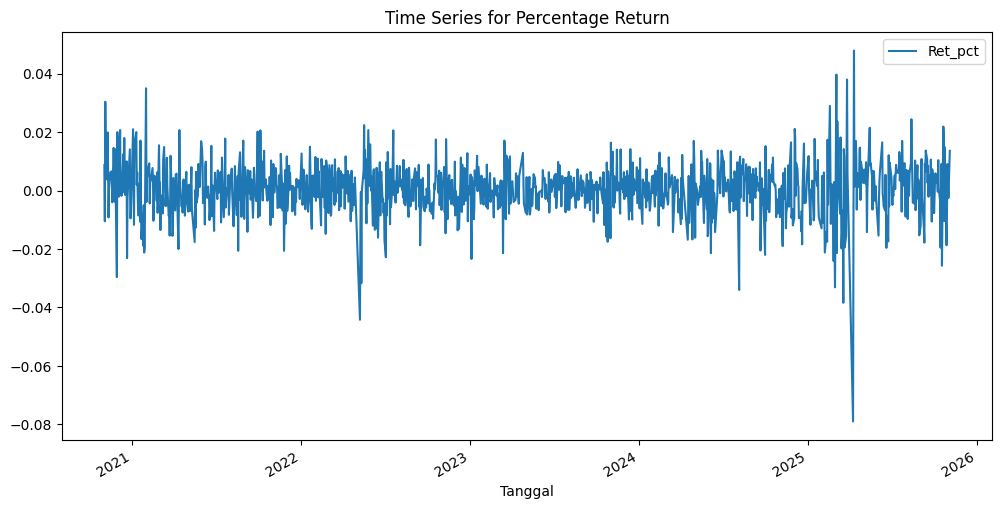

In [ ]:
data_var_harga = data_var[['Close','Open','High','Low']]
data_var_vol = data_var[['Vol_bil']]
data_var_per = data_var[['Ret_pct']]

# Plot time series data untuk visualisasi
data_var_harga.plot(figsize=(12, 6))
plt.title('Time Series for Daily Prices')
plt.show()

# Plot Percentage - Vol
data_var_vol.plot(figsize=(12, 6))
plt.title('Time Series for Percentage and Volume')
plt.show()

# Plot percentage return
data_var_per.plot(figsize=(12, 6))
plt.title('Time Series for Percentage Return')
plt.show()

In [ ]:

# Mengidentifikasi lag optimal menggunakan AIC, BIC, atau FPE
model = VAR(data_var)
lag_order = model.select_order(maxlags=15)  # Menentukan batas lag maksimal
print("Optimal lag order based on AIC:", lag_order.aic)

Optimal lag order based on AIC: 4


## Preliminary Analysis

Correlation Matrix:
             Close      Open      High       Low   Vol_bil   Ret_pct
Close    1.000000  0.995008  0.997566  0.998032  0.364389  0.032033
Open     0.995008  1.000000  0.998433  0.996598  0.366929 -0.054313
High     0.997566  0.998433  1.000000  0.997103  0.371887 -0.018894
Low      0.998032  0.996598  0.997103  1.000000  0.358268  0.003651
Vol_bil  0.364389  0.366929  0.371887  0.358268  1.000000 -0.001530
Ret_pct  0.032033 -0.054313 -0.018894  0.003651 -0.001530  1.000000


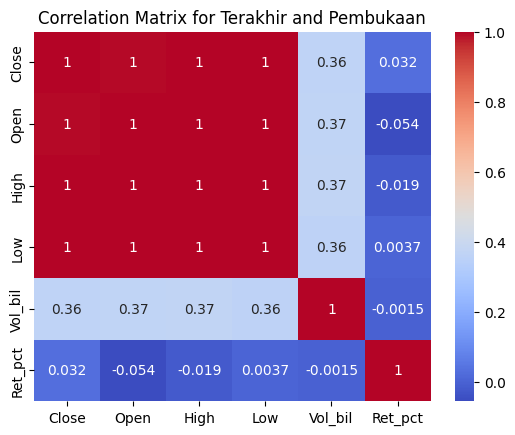

In [ ]:
# Cek korelasi antar variabel
correlation_matrix = data_var.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Visualisasi korelasi antar variabel
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Terakhir and Pembukaan')
plt.show()

## Uji Stasioner

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Uji ADF pada masing-masing kolom (Terakhir, Pembukaan)
def adf_test(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05  # p-value < 0.05 menunjukkan stasioneritas

for column in data_var.columns:
    p_value = adf_test(data_var[column])
    print(f"ADF p-value for {column}: {p_value}")

ADF p-value for Close: False
ADF p-value for Open: False
ADF p-value for High: False
ADF p-value for Low: False
ADF p-value for Vol_bil: True
ADF p-value for Ret_pct: True


In [ ]:
# Lakukan differencing pada tiap data_var
data_var_diff = data_var.diff().dropna()
for column in data_var_diff.columns:
    p_value = adf_test(data_var_diff[column])
    print(f"ADF p-value for {column} (Differencing): {p_value}")

ADF p-value for Close (Differencing): True
ADF p-value for Open (Differencing): True
ADF p-value for High (Differencing): True
ADF p-value for Low (Differencing): True
ADF p-value for Vol_bil (Differencing): True
ADF p-value for Ret_pct (Differencing): True


## Model Diagnostic

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, Nov, 2025
Time:                     02:29:27
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    15.7866
Nobs:                     1203.00    HQIC:                   15.3907
Log likelihood:          -19205.6    FPE:                3.80416e+06
AIC:                      15.1516    Det(Omega_mle):     3.36250e+06
--------------------------------------------------------------------
Results for equation Close
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             63.866609        24.427353            2.615           0.009
L1.Close           1.363325         0.362520            3.761           0.000
L1.Open            0.245000         0.099729            2.457           

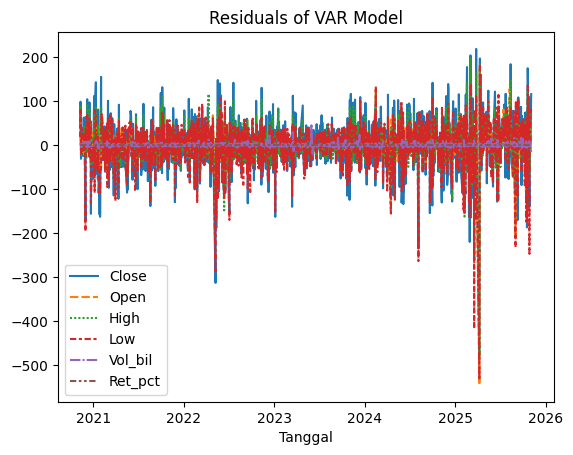

In [ ]:
# Fit VAR model dengan lag terbaik
model_fitted = model.fit(lag_order.aic)

# Output diagnosa untuk model yang sudah di-fit
print(model_fitted.summary())

# Cek residual model
residuals = model_fitted.resid
sns.lineplot(data=residuals)
plt.title('Residuals of VAR Model')
plt.show()

## Uji Heteroskedastisitas & Normalitas

In [ ]:
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.stattools import jarque_bera

print("DATA ASLI")
# Uji Heteroskedastisitas ARCH test
for column in data_var.columns:
  arch_test = het_arch(residuals[column])
  print(f"ARCH Test p-value for {column}: {arch_test[1]}")

DATA ASLI
ARCH Test p-value for Close: 5.321249085323578e-19
ARCH Test p-value for Open: 0.18077003141148218
ARCH Test p-value for High: 3.200012046364989e-11
ARCH Test p-value for Low: 7.226657403191277e-29
ARCH Test p-value for Vol_bil: 0.00017790732736208315
ARCH Test p-value for Ret_pct: 1.6880414562013364e-25


In [ ]:
# Uji Heteroskedastisitas ARCH test
print("DATA DIFF")
for column in data_var_diff.columns:
  arch_test = het_arch(residuals[column])
  print(f"ARCH Test p-value for {column}: {arch_test[1]}")

DATA DIFF
ARCH Test p-value for Close: 5.321249085323578e-19
ARCH Test p-value for Open: 0.18077003141148218
ARCH Test p-value for High: 3.200012046364989e-11
ARCH Test p-value for Low: 7.226657403191277e-29
ARCH Test p-value for Vol_bil: 0.00017790732736208315
ARCH Test p-value for Ret_pct: 1.6880414562013364e-25


In [ ]:
# Uji normalitas Jarque-Bera
for column in data_var.columns:
  jb_test = jarque_bera(residuals[column])
  print(f"Jarque-Bera Test p-value for {column}: {jb_test[1]}")

Jarque-Bera Test p-value for Close: 7.74081074470972e-258
Jarque-Bera Test p-value for Open: 0.0
Jarque-Bera Test p-value for High: 0.0
Jarque-Bera Test p-value for Low: 0.0
Jarque-Bera Test p-value for Vol_bil: 0.0
Jarque-Bera Test p-value for Ret_pct: 0.0


In [ ]:
for column in data_var_diff.columns:
  jb_test = jarque_bera(residuals[column])
  print(f"Jarque-Bera Test p-value for {column}: {jb_test[1]}")

Jarque-Bera Test p-value for Close: 7.74081074470972e-258
Jarque-Bera Test p-value for Open: 0.0
Jarque-Bera Test p-value for High: 0.0
Jarque-Bera Test p-value for Low: 0.0
Jarque-Bera Test p-value for Vol_bil: 0.0
Jarque-Bera Test p-value for Ret_pct: 0.0


## Stability & Granger Test

In [ ]:
# Uji stabilitas (Roots)
roots = model_fitted.roots
print("Roots:", roots)

Roots: [-3.41618192-0.j          2.51175413+1.5172029j   2.51175413-1.5172029j
  0.01319411+2.13230515j  0.01319411-2.13230515j  2.00481618-0.37448459j
  2.00481618+0.37448459j -1.12344159+1.69670413j -1.12344159-1.69670413j
 -1.92026344+0.48189512j -1.92026344-0.48189512j  0.23479144+1.9393027j
  0.23479144-1.9393027j  -1.80407437-0.j         -0.75869941-1.52807833j
 -0.75869941+1.52807833j -0.10385935+1.68103301j -0.10385935-1.68103301j
 -0.36802552+1.55283167j -0.36802552-1.55283167j  1.56151892-0.j
  1.28640521-0.j          1.0829699 -0.j          1.00814067-0.j        ]


In [ ]:
data_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1207 entries, 2020-11-03 to 2025-11-03
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Close    1207 non-null   float64
 1   Open     1207 non-null   float64
 2   High     1207 non-null   float64
 3   Low      1207 non-null   float64
 4   Vol_bil  1207 non-null   float64
 5   Ret_pct  1207 non-null   float64
dtypes: float64(6)
memory usage: 66.0 KB


In [ ]:
# # Uji Granger Causality (Terakhir -> Pembukaan)
# from statsmodels.tsa.stattools import grangercausalitytests
# gc_test = grangercausalitytests(data_var, maxlag=4, verbose=True)

## Impulse Response Function

## Peramalan

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 21.4 MB/s eta 0:00:00


In [ ]:
# Fit model VAR
model_var = VAR(data_var)

# Tentukan lag terbaik dengan AIC atau BIC
lag_order = model_var.select_order(maxlags=15).aic
model_var_fit = model_var.fit(lag_order)

# Tampilkan ringkasan model VAR
print(model_var_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, Nov, 2025
Time:                     03:44:00
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    4.35440
Nobs:                     1202.00    HQIC:                   3.81838
Log likelihood:          -13836.1    FPE:                    32.9354
AIC:                      3.49448    Det(Omega_mle):         27.8733
--------------------------------------------------------------------
Results for equation Close
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             62.360082        24.481101            2.547           0.011
L1.Close           1.402264         0.364535            3.847           0.000
L1.Open            0.252744         0.099829            2.532           

In [ ]:
from statsmodels.stats.diagnostic import het_arch

# Ambil residual dari model VAR
residuals_var = model_var_fit.resid

# Uji ARCH untuk heteroskedastisitas
arch_test = het_arch(residuals_var['Close'])  # Ganti 'Close' dengan kolom lain jika diperlukan
print("ARCH Test p-value:", arch_test[1])

if arch_test[1] < 0.05:
    print("Ada heteroskedastisitas (varians residual tidak konstan)")
else:
    print("Tidak ada heteroskedastisitas (model stabil)")

ARCH Test p-value: 7.106604940915472e-19
Ada heteroskedastisitas (varians residual tidak konstan)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 6274.047020890652
Iteration:      2,   Func. Count:     15,   Neg. LLF: 6513.821621425674
Iteration:      3,   Func. Count:     24,   Neg. LLF: 278698881.29167676
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1646.8304300000964
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1497.1546583225945
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1496.8535199974194
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1496.703604685409
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1496.6663440477403
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1496.6639401577352
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1496.6638981298602
Iteration:     11,   Func. Count:     67,   Neg. LLF: 1496.6638776080135
Iteration:     12,   Func. Count:     72,   Neg. LLF: 1496.6638770182244
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1496.6638770182244
            Iterat

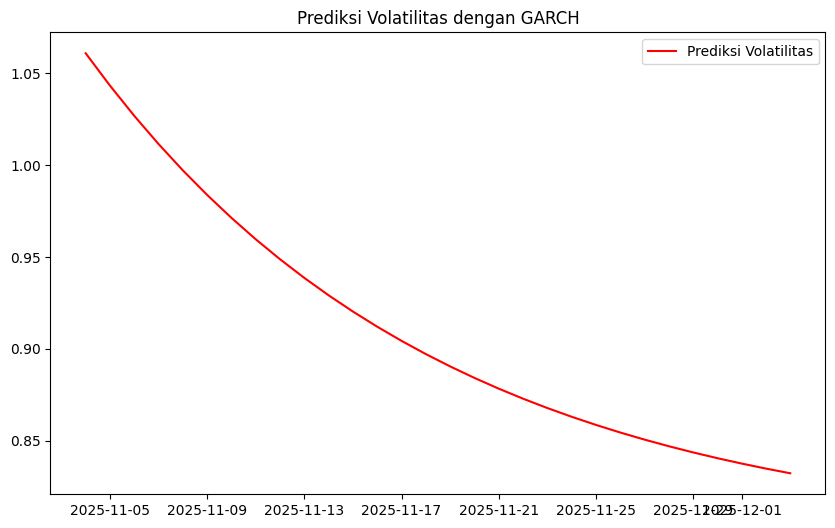

In [ ]:
from arch import arch_model

# Menggunakan return saham sebagai input untuk model GARCH
df['Return_Close'] = df['Close'].pct_change() * 100  # Menghitung return

# Fit model GARCH(1, 1) pada return
garch_model = arch_model(df['Return_Close'].dropna(), vol='Garch', p=1, q=1)
garch_fit = garch_model.fit()

# Prediksi volatilitas untuk beberapa langkah ke depan (misalnya 30 hari)
forecast_volatility = garch_fit.forecast(horizon=30)

# Ambil volatilitas yang diprediksi
forecast_volatility_df = pd.DataFrame(forecast_volatility.variance.values[-1, :],
                                      index=pd.date_range(df.index[-1], periods=31, freq='D')[1:],
                                      columns=['Volatility'])

# Visualisasi hasil volatilitas yang diprediksi
plt.figure(figsize=(10, 6))
plt.plot(forecast_volatility_df.index, forecast_volatility_df['Volatility'], color='red', label='Prediksi Volatilitas')
plt.title('Prediksi Volatilitas dengan GARCH')
plt.legend()
plt.show()

In [ ]:
# Forecast untuk beberapa langkah ke depan
forecast_steps = 150
forecast_var = model_var_fit.forecast(data_var.values[-lag_order:], steps=forecast_steps)

# Cek bentuk hasil forecast
print(forecast_var.shape)  # Mengecek jumlah kolom yang dihasilkan oleh model VAR

(150, 7)


In [ ]:
# Misalnya, hasil forecast memiliki 4 kolom, maka sesuaikan kolomnya
forecast_var_df = pd.DataFrame(forecast_var,
                               index=pd.date_range(df.index[-1], periods=forecast_steps+1, freq='D')[1:],
                               columns=data_var.columns)  # Sesuaikan dengan kolom yang ada pada data

# Tampilkan hasil forecast
print(forecast_var_df.head())


                  Close         Open         High          Low    Vol_bil  \
2025-11-04  8267.395279  8279.628182  8315.234320  8220.924124  20.748160   
2025-11-05  8260.175676  8273.305487  8307.047186  8209.015597  22.345902   
2025-11-06  8266.010943  8275.445429  8307.945769  8234.101480  20.384264   
2025-11-07  8253.836141  8268.892516  8305.927067  8217.250424  20.692357   
2025-11-08  8240.916539  8256.034615  8293.041550  8199.025439  21.459952   

             Ret_pct    Return  
2025-11-04 -0.001320 -0.132661  
2025-11-05 -0.001036 -0.102944  
2025-11-06  0.000187  0.018619  
2025-11-07 -0.001894 -0.189663  
2025-11-08 -0.002018 -0.201955  


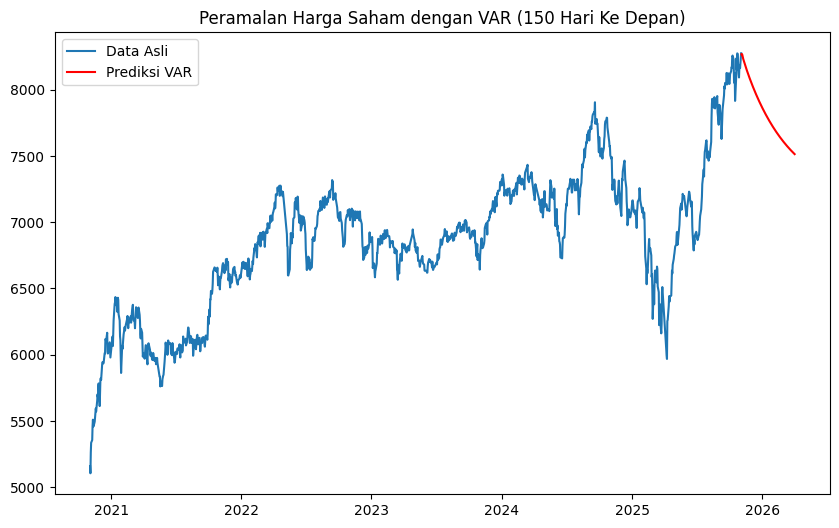

In [ ]:
# Visualisasi hasil forecasting VAR
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Data Asli')
plt.plot(forecast_var_df.index, forecast_var_df['Close'], color='red', label='Prediksi VAR')
plt.title(f'Peramalan Harga Saham dengan VAR ({forecast_steps} Hari Ke Depan)')
plt.legend()
plt.show()

In [ ]:
forecast_combined_df.head()

,Close,Open,High,Low,Vol_bil,Ret_pct,Return,Volatility
2025-11-04,8267.395279,8279.628182,8315.234320,8220.924124,20.748160,-0.001320,-0.132661,1.060980
2025-11-05,8260.175676,8273.305487,8307.047186,8209.015597,22.345902,-0.001036,-0.102944,1.043348
2025-11-06,8266.010943,8275.445429,8307.945769,8234.101480,20.384264,0.000187,0.018619,1.026890
2025-11-07,8253.836141,8268.892516,8305.927067,8217.250424,20.692357,-0.001894,-0.189663,1.011530
2025-11-08,8240.916539,8256.034615,8293.041550,8199.025439,21.459952,-0.002018,-0.201955,0.997193


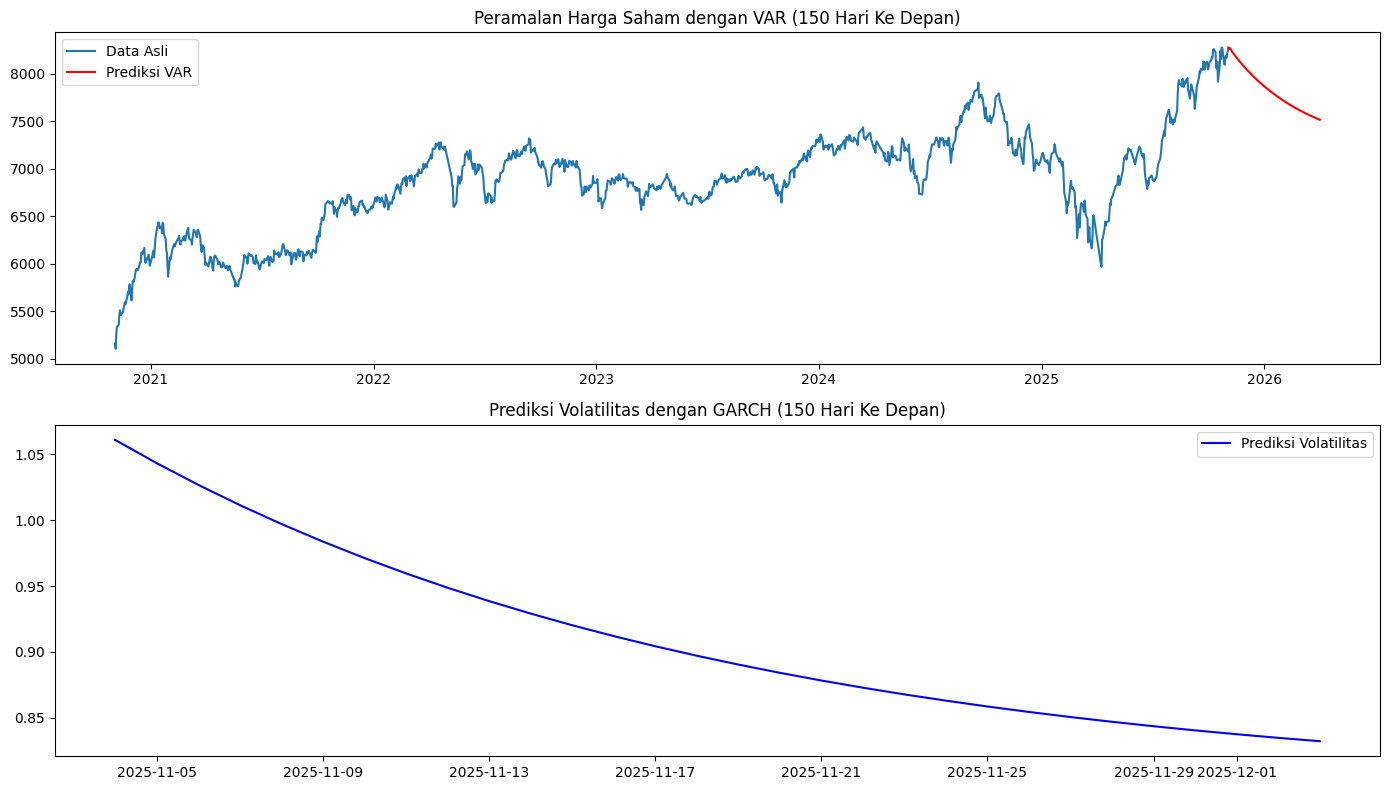

In [ ]:
# Gabungkan hasil forecast VAR dan volatilitas GARCH
forecast_combined_df = forecast_var_df.join(forecast_volatility_df)

# Visualisasi gabungan hasil forecast (harga dan volatilitas)
plt.figure(figsize=(14, 8))

# Plot harga yang diprediksi dengan VAR
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Data Asli')
plt.plot(forecast_combined_df.index, forecast_combined_df['Close'], color='red', label='Prediksi VAR')
plt.title(f'Peramalan Harga Saham dengan VAR ({forecast_steps} Hari Ke Depan)')
plt.legend()

# Plot volatilitas yang diprediksi dengan GARCH
plt.subplot(2, 1, 2)
plt.plot(forecast_combined_df.index, forecast_combined_df['Volatility'], color='blue', label='Prediksi Volatilitas')
plt.title(f'Prediksi Volatilitas dengan GARCH ({forecast_steps} Hari Ke Depan)')
plt.legend()

plt.tight_layout()
plt.show()